# Programming Probabilistically (mod1-part3)

## Gaussian Inferences

We finally change exercise :) --- hey, have you taken a look at the [PyScript version of the coin flipping problem](https://cfteach.github.io/pyscr/) before jumping to this new exercise? 

The reference for this new exercise is [1] (one of our reference textbooks in our course), from which this exercise is taken.   

We use a dataset that comes from **Nuclear Magnetic Resonance (NMR)**, a powerful tehcnique that is used to study molecules.
NMR allows to measure *chemical shifts* from nuclei of certain types of atmos. In quantum chemistry chemical shifts correspond to a signal shift from a reference value in the chemical environemnt that we are studying. 

We could have measured the height of a group of people or the average time to travel back home, c'est la meme chose... 

We do not need that our data is truly Gaussian (or any other distribution): we only demand that a Guassian distribution is a resoanble approximation of our data.
For this example, we have 48 chemical shifts values that we can load into a NumPy array and plot by using the following code:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
import requests
import requests

In [2]:
az.style.use('arviz-darkgrid')

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC3 v3.11.5
Running on ArviZ v0.12.1


In [3]:
import io
import csv 
import requests

target_url = 'https://raw.githubusercontent.com/cfteach/brds/main/datasets/chemical_shifts.csv' 

download = requests.get(target_url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))


data=df.iloc[:,0].values

print(data)

[55.12 53.73 50.24 52.05 56.4  48.45 52.34 55.65 51.49 51.86 63.43 53.
 56.09 51.93 52.31 52.33 57.48 57.44 55.14 53.93 54.62 56.09 68.58 51.36
 55.47 50.73 51.94 54.95 50.39 52.91 51.5  52.68 47.72 49.73 51.82 54.99
 52.84 53.19 54.52 51.46 53.73 51.61 49.81 52.42 54.3  53.84 53.16]


The KDE plot of this dataset shows a Gaussian-like distribution, except for two data points that are far away from the mean:

([<matplotlib.axis.YTick at 0x1673a26b0>], [Text(0, 0, '')])

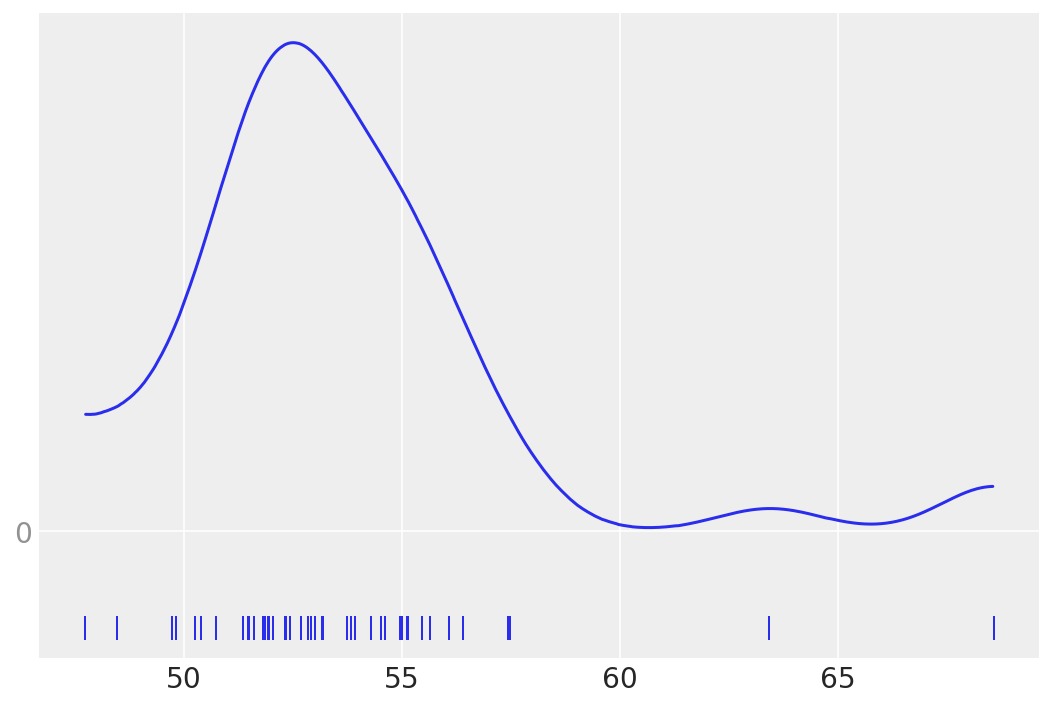

In [4]:
az.plot_kde(data, rug=True)

#rug plots https://en.wikipedia.org/wiki/Rug_plot 

plt.yticks([0], alpha=0.5)


Let's forget about those two "outliers" for a moment, and assume that a Gaussian distribution is a proper description of the data. 

Since we do not know the mean and standard deviation, we must set priors for both of them. 

Let's build a resonable model; this could be:

$\mu$ $\sim$ $U(l,u)$ 

$\sigma$ $\sim$ |$\mathcal{N}(0,\sigma_{\sigma})$|

y $\sim$ $\mathcal{N}$($\mu$,$\sigma$)

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-question-circle" aria-hidden="true"></i>&nbsp; Question</b><br>
    <p style="color: black">
        What is the meaning of this model?
   </p>
</div>

If we do not know the possible values of $\mu$ and $\sigma$, we can set priors on them to reflect our ignorance on these parameters. 

Using PyMC3, we can write the model as follows:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


/Users/thushanthytilakahettige/Desktop/teaching/BRDS/test_pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/thushanthytilakahettige/Desktop/teaching/BRDS/test_pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/thushanthytilakahettige/Desktop/teaching/BRDS/test_pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/thushanthytilakahettige/Desktop/teaching/BRDS/test_pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

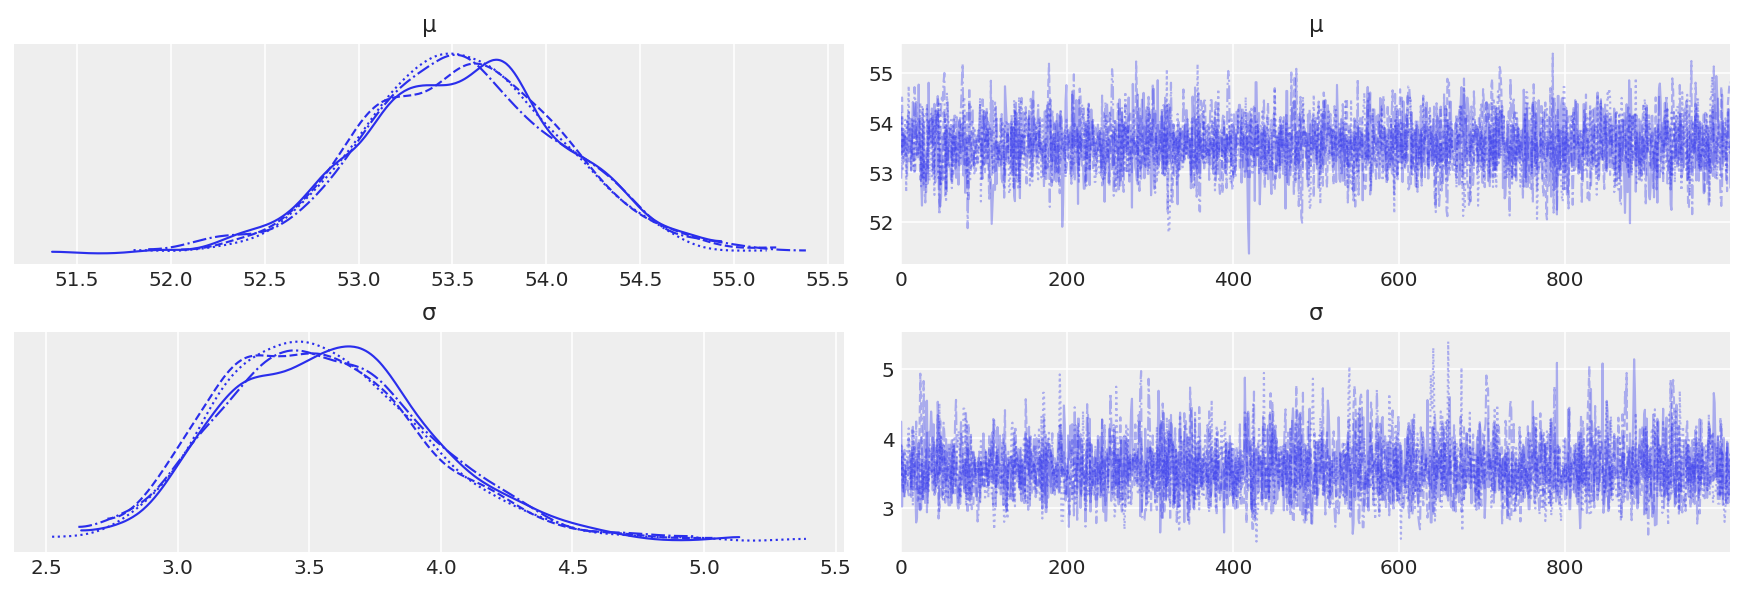

In [5]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower = 40, upper = 70)
    σ = pm.HalfNormal('σ', sd = 10)
    y = pm.Normal('y', mu=μ, sd =σ, observed=data)
    trace_g = pm.sample(1000, return_inferencedata=True)
az.plot_trace(trace_g)


In [ ]:
az.plot_pair(trace_g, kind='kde', fill_last=False, marginals=True)



<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Note</b><br>
    <p style="color: black">
    To get access to the values of any of the parameters stored in a `trace` object, you can index the trace with the name of the parameter. 

E.g., `trace_g['σ']` or `a.plot_kde(trace_g['σ'])`
        
   </p>
</div>




In [6]:
az.summary(trace_g)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  53.554  0.527  52.616   54.567      0.009    0.006    3360.0    2766.0   
σ   3.565  0.394   2.881    4.310      0.007    0.005    2862.0    2222.0   

   r_hat  
μ    1.0  
σ    1.0

### Posterior Predictive Checks

We can use the posterior to generate predictions --- e.g, each of which of the same size of the data. We can check consistency with data. This is a self-consistency check that is allowed by Bayesian Reasoning: it is possible to generate predictions $\tilde{y}$, based on data $y$, and the estimated parameters $\theta$:

$p(\tilde{y}|y)$=$\int{p(\tilde{y}|\theta)}p(\theta|y) d\theta$

We can use the predicted $\tilde{y}$ and compare to our data $y$ to criticize our model. Models should always be checked. 


In [7]:
# let's generate 100 predictions from the posterior 
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g) 


/Users/thushanthytilakahettige/Desktop/teaching/BRDS/test_pymc3/lib/python3.10/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


The `y_pred_g` variable is a dictionary, with the `keys` being the name of the observed variable in our model and the `values` being an array of shape `(samples, size)`, in this case `(100, len(data))`.

We have a dictionary because we could have models with more than one variable. 

We can use the `plot_ppc`(**posterior predictive check**) function for a visual posterior predictive check:

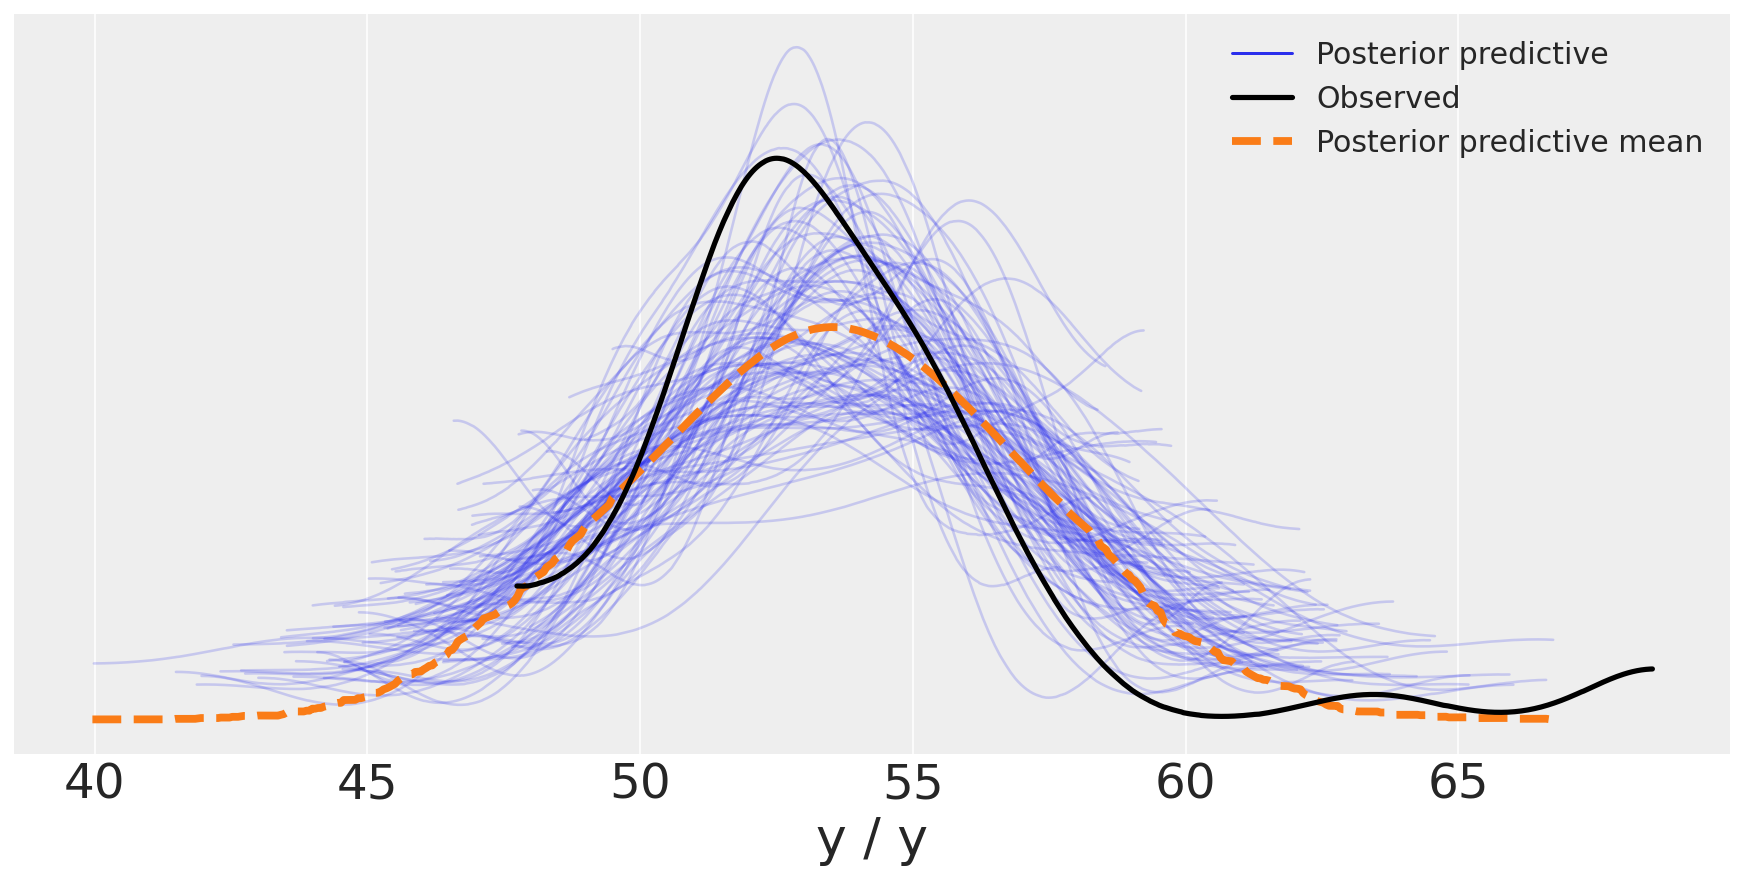

In [17]:
data_ppc = az.from_pymc3(posterior_predictive=y_pred_g, model=model_g)
#data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
        
ax = az.plot_ppc(data_ppc, figsize=(12,6), mean=True)
ax.legend(fontsize=15)


<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Note</b><br>
    <p style="color: black">
    You may argue that the two outliers at large values of the chemical shifts are influencing the results, i.e. making the Gaussian with a larger standard deviation. You can remove those outliers... Bayesian rather prefer to change the model with different priors and likelihoods, rather than ad hoc heuristics such as outlier removal.   
        
      
        
   </p>
</div>





One very useful option is replacing the Gaussian likelihood with a Student's t-distribution

### Student's t Distribution

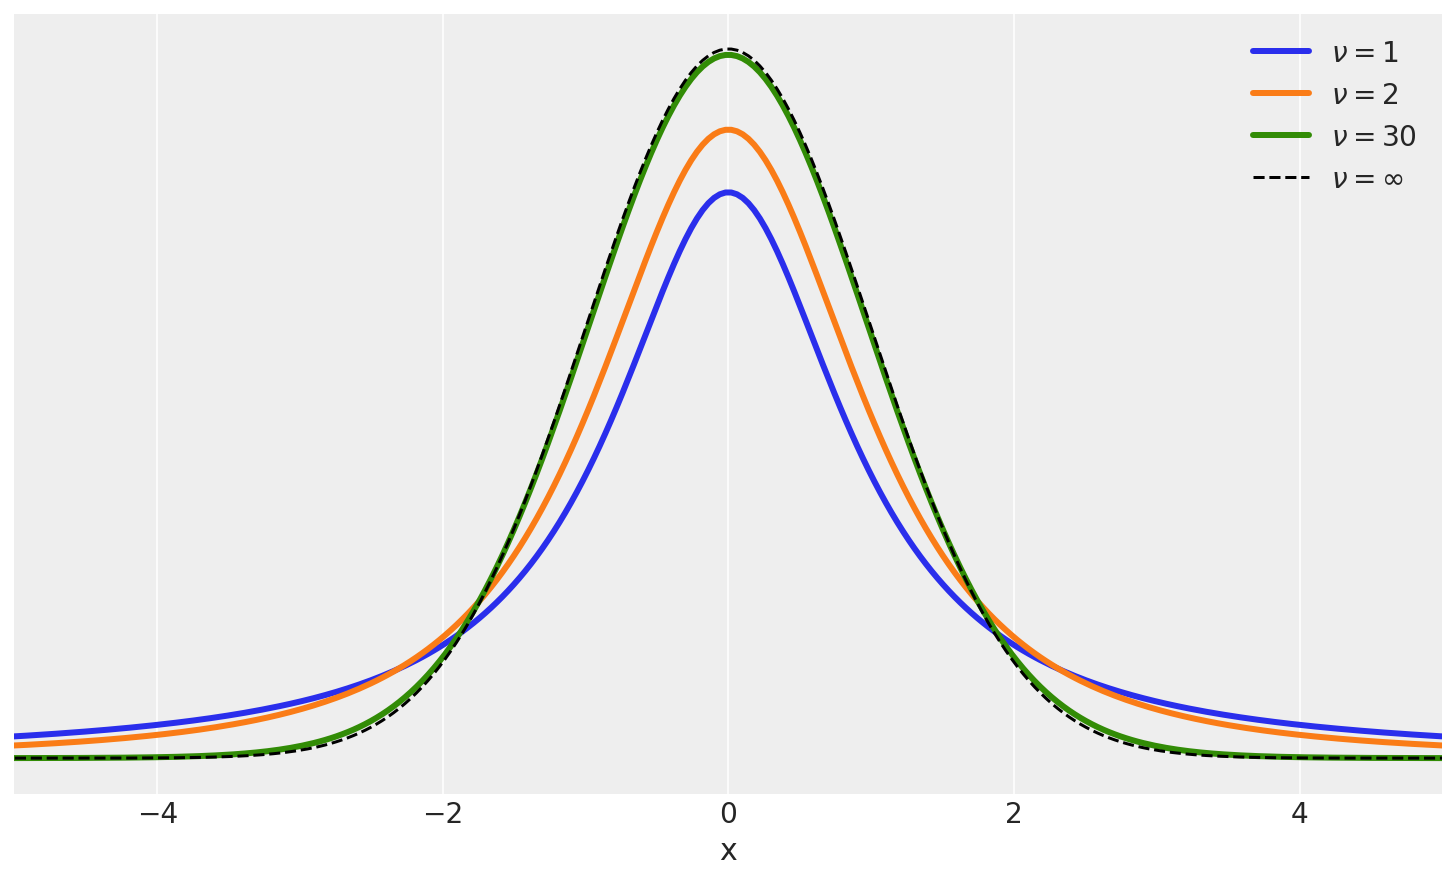

In [19]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)
plt.savefig('./output/B11197_02_12.png', dpi=300)

For the t-distribution, we now have three parameters to consider, $\mu$, $\sigma$ and $\nu$. Please see notes in class. 

This will reflect in our model according to:



<block>

$\mu \sim U(l,u)$ --- uniform (**Prior on $\mu$**)

$\sigma \sim |\mathcal{N}(0,\sigma_{\sigma})|$ --- positive-defined and normal-like (**Prior on $\sigma$**)

$\nu \sim Exp(\lambda)$ --- exponential (**Prior on $\nu$**)

$y \sim \mathcal{T(\mu,\sigma, \nu)}$ --- t-Studentd (**Likelihood**)

</block>

In [40]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000,tune=5000,return_inferencedata=True)
    
#  step size adaptation, which gives you fewer parameters to tune, and adds in the concept of “warmup” or “tuning” for your sampler.
# https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Exponential.html 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]


/Users/thushanthytilakahettige/Desktop/teaching/BRDS/test_pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/thushanthytilakahettige/Desktop/teaching/BRDS/test_pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/thushanthytilakahettige/Desktop/teaching/BRDS/test_pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/thushanthytilakahettige/Desktop/teaching/BRDS/test_pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 7 seconds.


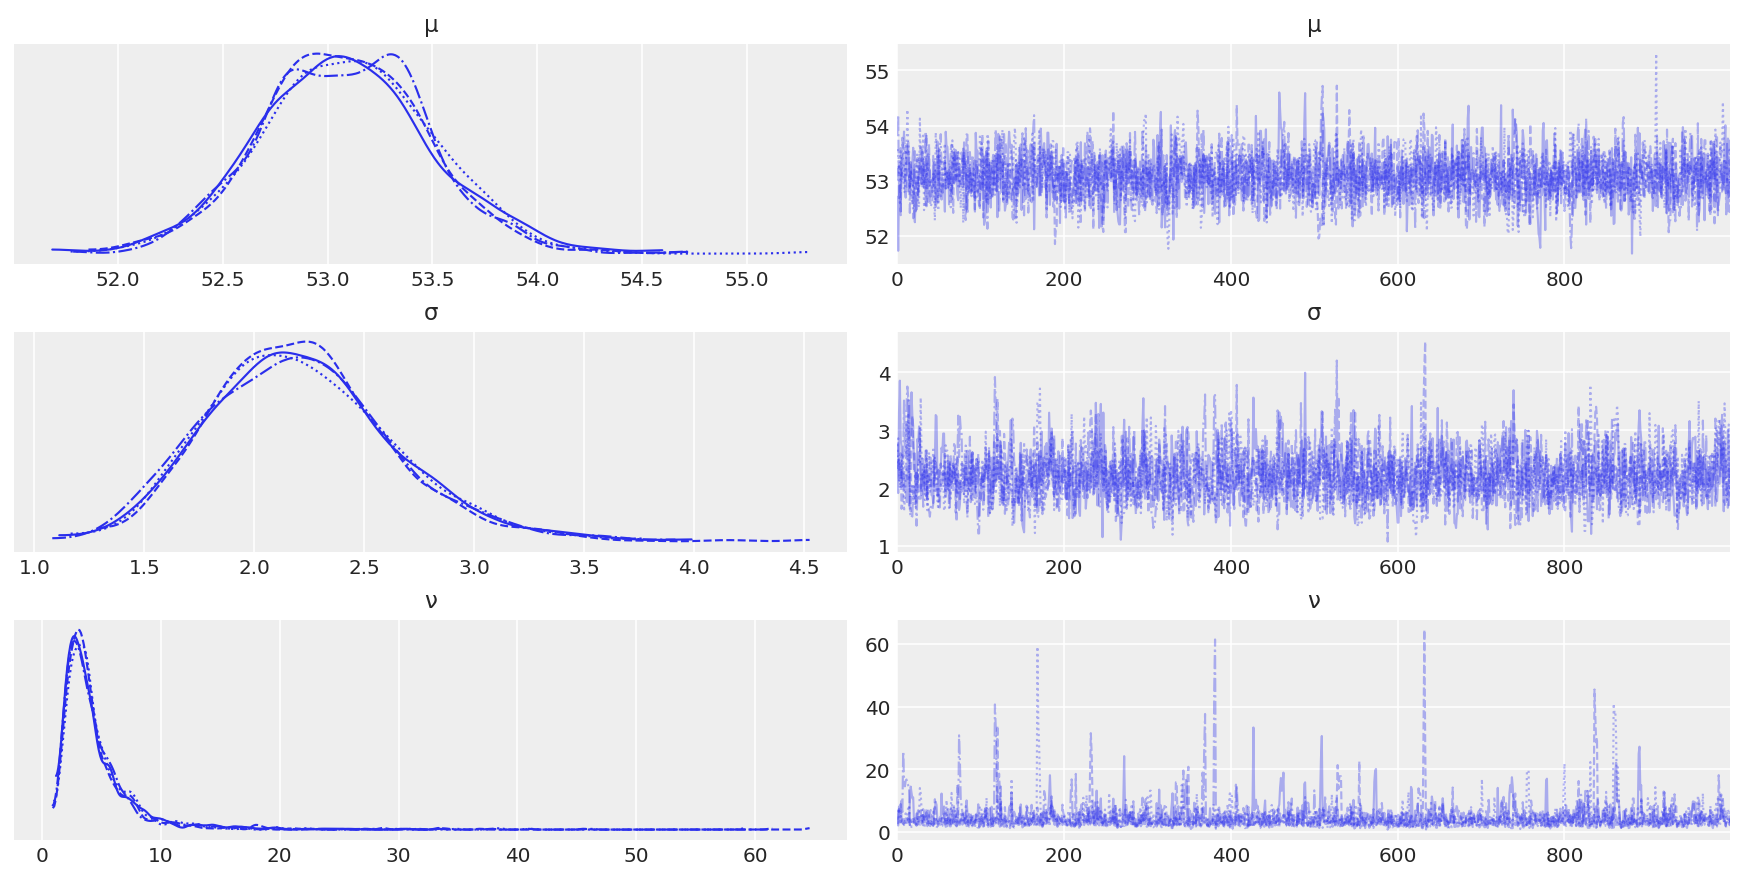

In [41]:
az.plot_trace(trace_t)
plt.savefig('./output/B11197_02_14.png', dpi=300)

In [42]:
az.summary(trace_t)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  53.082  0.399  52.319   53.820      0.008    0.006    2614.0    2458.0   
σ   2.214  0.420   1.485    3.019      0.010    0.007    1947.0    2008.0   
ν   4.604  3.983   1.251    9.614      0.104    0.073    1854.0    1582.0   

   r_hat  
μ    1.0  
σ    1.0  
ν    1.0

/Users/thushanthytilakahettige/Desktop/teaching/BRDS/test_pymc3/lib/python3.10/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


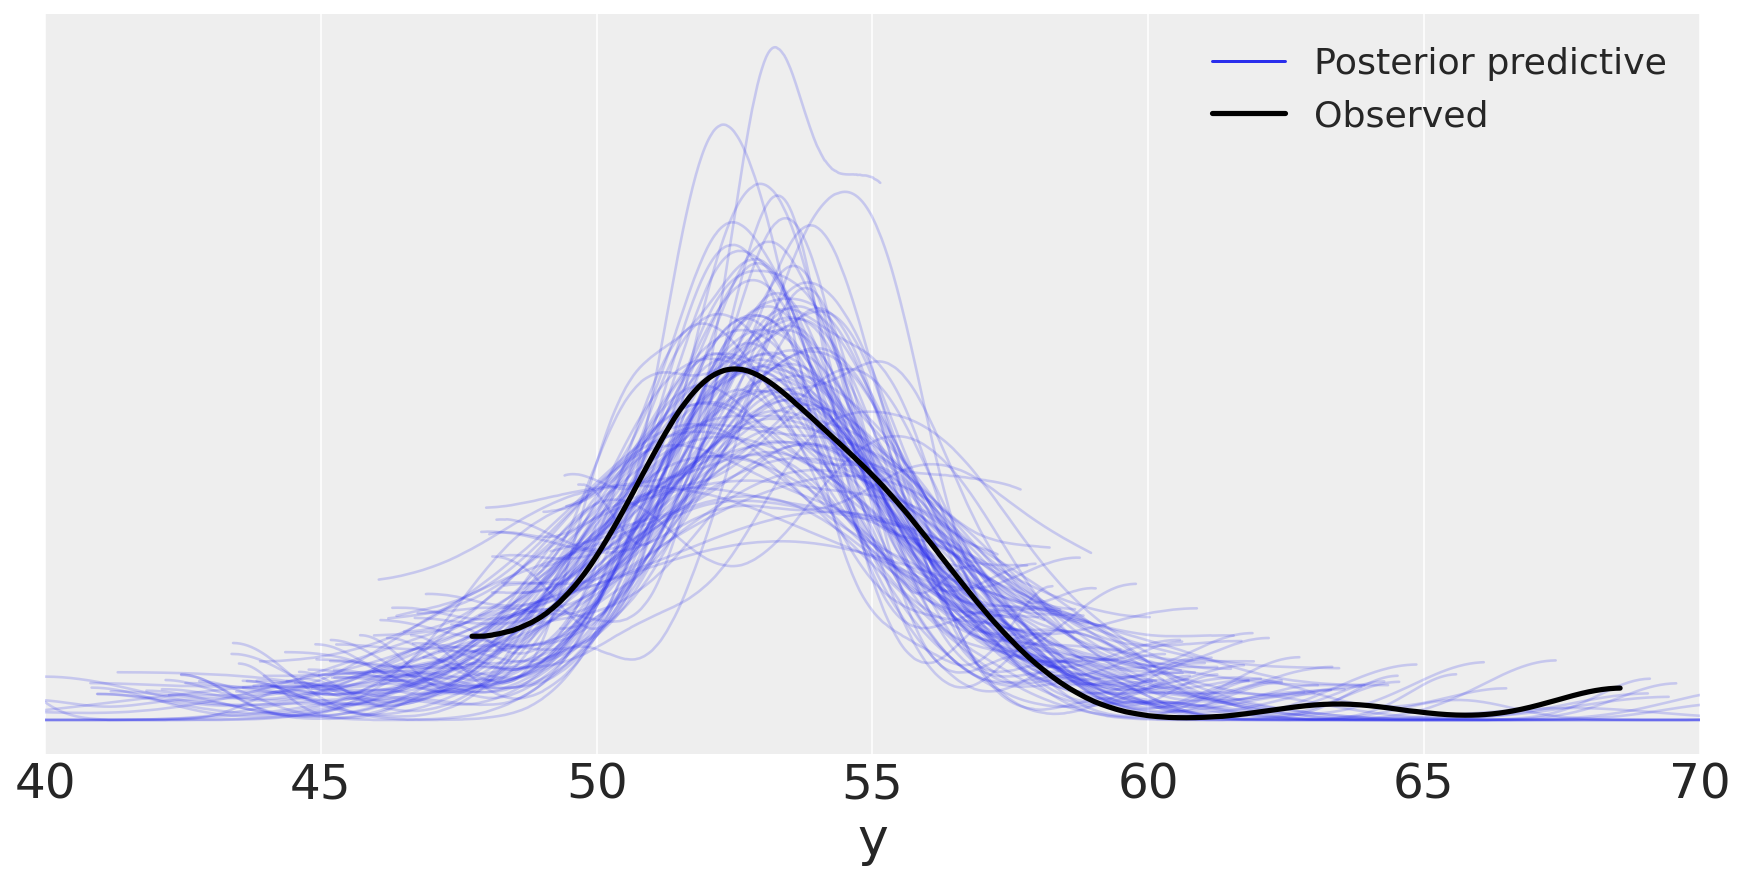

In [43]:
y_ppc_t = pm.sample_posterior_predictive(
    trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(posterior_predictive=y_ppc_t, model=model_t)
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=False)
ax.legend(fontsize=15)
plt.xlim(40, 70)
plt.xlabel('y')
plt.savefig('./output/B11197_02_15.png', dpi=300)

## References

[1] O. Martin, Bayesian Analysis with Python, 2018 